In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Nusselt(Re,Pr,externo=True):
    if externo:
        if Re < 10**5:
            return 0.664*Re**(1/2)*Pr**(1/3)
        else:
            return 0.037*(Re**(4/5)-871)*Pr**(1/3)
    else:
        if Re < 10**4:
            return 4.36
        else:
            return 0.023*Re**(4/5)*Pr**(1/3)

def Prandtl(nu,k_f,rho,c_p):
    alfa = k_f/(rho*c_p)
    return nu/alfa

def Reynolds(v,L,nu):
    return v*L/nu

def conveccion(nu,k_f,rho,c_p,v,L,externo=True):
    Re = Reynolds(v,L,nu)
    Pr = Prandtl(nu,k_f,rho,c_p)
    
    Nu = Nusselt(Re,Pr,externo=externo)
    
    return k_f*Nu/L

In [3]:
# Condiciones impuestas -------------------------------------------------------
Q = 60*10**3 # Watts
T_max = 500 #°C

# Condiciones de la pieza ----------------------------------------------------
L = 0.3 # metros
l = 1 # metros
k_pieza = 200 # W/(m°C)

A_gen = (0.25*L)**2
A_cond = L**2
P_cond = 4*L
q_vol = Q/(A_gen*l)/12
D = 4*A_cond/P_cond

# Condiciones de flujo interno ----------------------------------------------
T_entrada = 25 #°C
v_f = 5 # m/s
k_f = 0.5918 # W/(m°C)
rho_f = 1000 # kg/m^3
nu_f = 1.004e-6 # m^2/s
cP_f = 4.186e3 #J/kg

# Condiciones de flujo externo -----------------------------------------------
T_inf = 25 # °C
v_a = 5 # m/s
k_a = 0.026 # W/(m°C)
rho_a = 1.2 # kg/m^3
nu_a = 1.1516e-5 # m^2/s
cP_a = 1.006e3 #J/kg

In [7]:
# Variables adimensionales ------------------------------------------------------
h_e = conveccion(nu_a,k_a,rho_a,cP_a,v_a,L,externo=True)*L/k_pieza
h_i = conveccion(nu_f,k_f,rho_f,cP_f,v_f,D,externo=False)*L/k_pieza
q = q_vol*L**2/(k_pieza*T_inf)
th_i = 0

particion = 20
ND = particion+1
NumVariables = ND**2

d = 1/particion

In [8]:
# Matriz de coeficientes ------------------------------------------------------------------
A = np.zeros((NumVariables,NumVariables))
y = np.zeros(NumVariables) 

# Lleno ecuaciones de nodos internos -----------------------------------------------------------
for alfa in range(22,41): #el índice alfa recorre los nodos de izquierda a derecha
    for beta in 21*np.arange(0,19): #el índice beta recorre los nodos de arriba a abajo
        i = alfa+beta
        A[i,i] = -4
        A[i,i-1] = 1; A[i,i+1]=1; A[i,i-21]=1; A[i,i+21]=1

# Llena los nodos (triviales) en el canal de refrigeración --------------------------------------------------
for alfa in range(21*15+1,21*15+6): 
    for beta in 21*np.arange(0,5):
        i = alfa+beta
        A[i,i] = 1
        A[i,i-1] = 0; A[i,i+1]=0; A[i,i-21]=0; A[i,i+21]=0
        y[i] = th_i

# Lleno ecuaciones de nodos de borde --------------------------------------------------------------
for alfa in range(1,20): 
    i = alfa # recorre el borde superior
    A[i,i] = -2*(h_e*d + 2)
    A[i,i-1] = 1; A[i,i+1] = 1; A[i,i+21] = 2;
    
    i = 21*alfa # recorre el borde izquierdo (implementando condición de simetría)
    A[i,i] = -4
    A[i,i+1] = 2; A[i,i+21] = 1; A[i,i-21] = 1;
    
    i = 20 + 21*(alfa) #recorre el borde derecho
    A[i,i] = -2*(h_e*d + 2)
    A[i,i-1] = 2; A[i,i-21] = 1; A[i,i+21] = 1;
    
    i = 420 + alfa # recorre el borde inferior (implementando condición de simetría)
    A[i,i] = -4
    A[i,i-21] = 2; A[i,i-1] = 1; A[i,i+1] = 1;

# Llena los nodos (triviales) en el canal de refrigeración ----------------------------------------------------------
for alfa in range(0,5): 
    i = 21*15 + 21*alfa # recorre el borde izquierdo del canal
    A[i,i] = 1
    A[i,i+1] = 0; A[i,i+21] = 0; A[i,i-21] = 0;
    y[i] = th_i
    
    i = 21*20 + 1 + alfa #recorre el borde inferior del canal
    A[i,i] = 1
    A[i,i-21] = 0; A[i,i-1] = 0; A[i,i+1] = 0;
    y[i] = th_i


# Llena los nodos en el borde del canal de refrigeración ----------------------------------------------------------
for alfa in range(4): 
    i = 341 + 21*alfa # Recorre el borde derecho
    A[i,i] = -2*(h_i*d + 2)
    A[i,i-21] = 1; A[i,i+21] = 1; A[i,i+1] = 2
    y[i] = -2*h_i*d*th_i
    
    i = 21*15 + alfa+1 # Recorre el borde superior
    A[i,i] = -2*(h_i*d + 2)
    A[i,i-1] = 1; A[i,i+1] = 1; A[i,i-21] = 2
    y[i] = -2*h_i*d*th_i

# Llena nodos restantes ----------------------------------------------------------------------

A[0,0] = -2*(h_e*d + 2); A[0,1] = 2; A[0,21] = 2 # Nodo de borde externo con condición de simetría
A[440,440] = -2*(h_e*d + 2); A[440,419] = 2; A[440,439] = 2 # Nodo de borde externo  con condición de simetría

A[420,420] = 1; y[420] = th_i
A[315,315] = -2*(h_i*d + 2); A[315,316] = 2; A[315,315-21] = 2 # Nodo de borde interno con condición de simetría
A[425,425] = -2*(h_i*d + 2); A[425,404] = 2; A[425,426] = 2 # Nodo de borde interno con condición de simetría

A[20,20] = -2*(h_e*d + 1); A[20,19] = 1; A[20,41] = 1 # Nodo de esquina

# Nodo de esquina interna
A[320,320] = -2*(3+h_i*d); A[320,320-1] = 1; A[320,320+1] = 2; A[320,320-21] = 2; A[320,320+21] = 1
y[320] = -2*h_i*d*th_i

# Asigna los nodos con generación de calor  --------------------------------------------------------------
for alfa in range(21*5+10,21*5+16):
    for beta in 21*np.arange(0,6):
        i = alfa+beta
        y[i] = -q*d**2
        
        i = alfa+beta-10
        y[i] = -q*d**2
        
        i = alfa+beta + 210
        y[i] = -q*d**2

# Solución ----------------------------------------------------------------
thetas = np.matmul(np.linalg.inv(A),y)
thetas2 = thetas.reshape((21,21))

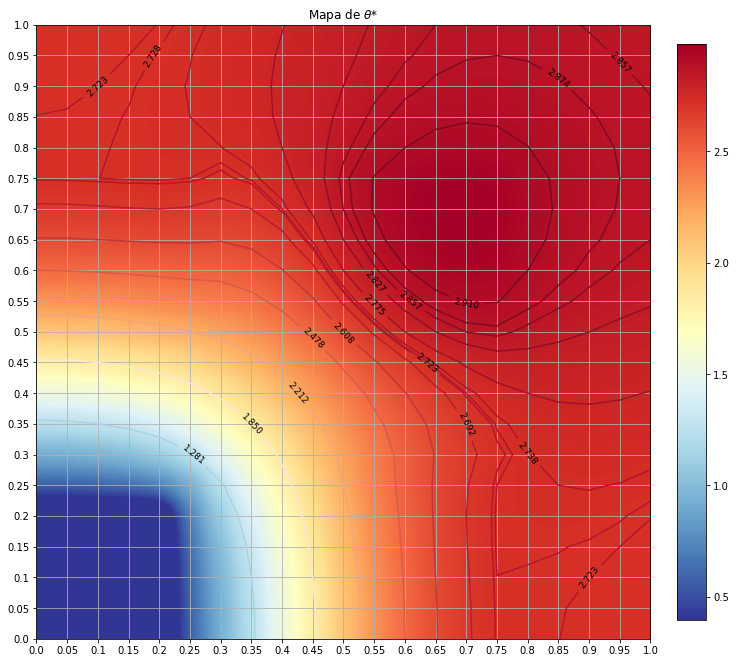

In [9]:
# Mapa de calor --------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,12))
min_col = min(thetas[np.where(thetas!=0.)])/1.5
mapa = ax.imshow(thetas2,cmap='RdYlBu_r',interpolation='gaussian',vmin=min_col,vmax=max(thetas)) #afmhot RdBu_r ,interpolation='gaussian'
plt.ylim(21,-1)
plt.xlim(0,20)
plt.yticks(np.arange(21),np.round(1-np.arange(0,21)/20,decimals=2))
plt.xticks(np.arange(21),np.arange(21)/20)
plt.colorbar(mapa,fraction=0.043, pad=0.04)
ax.grid()
plt.title(r'Mapa de $\theta$*')

# Líneas de contorno --------------------------------------------------------
cat = np.sort(thetas[np.where(thetas!=0.)])[np.array(len(thetas[np.where(thetas!=0.)])/15*np.arange(1,15),dtype=int)]
cont = ax.contour(thetas2,levels=cat,cmap='RdBu_r',vmin=min_col,vmax=max(thetas))
ax.clabel(cont, inline=1, fontsize=9,colors='black')
plt.show()

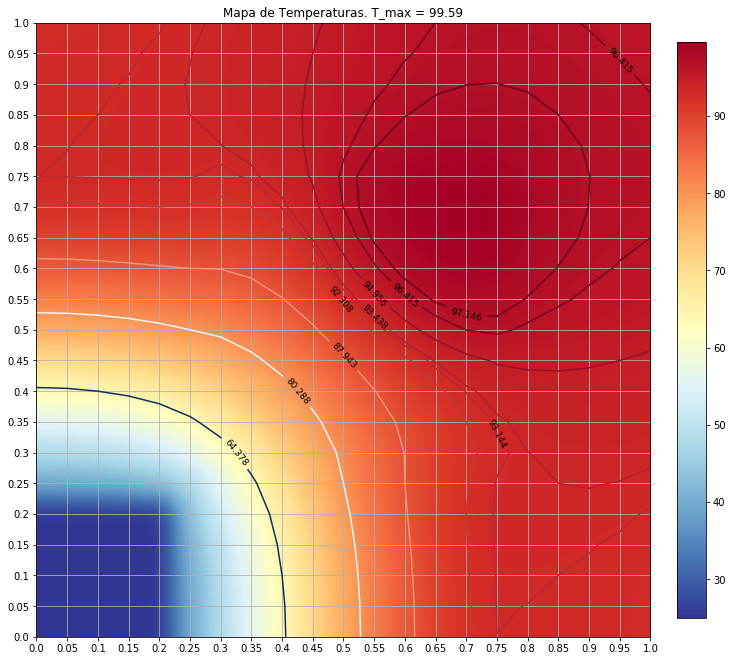

In [13]:
Temp = thetas2*T_inf+T_inf
Temp2 = thetas*T_inf+T_inf

# Mapa de calor --------------------------------------------------------------
fig,ax = plt.subplots(figsize=(12,12))
min_col = min(thetas[np.where(thetas!=0.)])/1.5
mapa = ax.imshow(Temp,cmap='RdYlBu_r',interpolation='gaussian') #afmhot RdBu_r ,interpolation='gaussian'
plt.ylim(21,-1)
plt.xlim(0,20)
plt.yticks(np.arange(21),np.round(1-np.arange(0,21)/20,decimals=2))
plt.xticks(np.arange(21),np.arange(21)/20)
plt.colorbar(mapa,fraction=0.043, pad=0.04)
ax.grid()
plt.title(r'Mapa de Temperaturas. T_max = {:.2f}'.format(np.max(Temp2)))

# Líneas de contorno --------------------------------------------------------
cat = np.sort(Temp2[np.where(thetas!=0.)])[np.array(len(thetas[np.where(thetas!=0.)])/10*np.arange(1,10),dtype=int)]
cont = ax.contour(Temp,levels=cat,cmap='RdBu_r')
ax.clabel(cont, inline=1, fontsize=9,colors='black')
plt.show()